In [19]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>''')

<a name="Top"></a>

In [20]:
from IPython.display import HTML
HTML('''
<style>
    .yourDiv {position: fixed;top: 100px; right: 0px; 
              background: white;
              height: 100%;
              width: 300px; 
              padding: 20px; 
              z-index: 10000}
</style>
<script>
function showthis(url) {
	window.open(url, "pres", 
                "toolbar=yes,scrollbars=yes,resizable=yes,top=10,left=400,width=500,height=500");
	return(false);
}
</script>

<div class=yourDiv>
    <h4>MENU</h4><br>
    <a href=#Data>1. Data</a><br>
    <a href=#SpatialCoverage>2. Spatial Coverage</a><br>
    <a href=#TemporalCoverage>3. Temporal Coverage</a><br>
    <a href=#ClassOverlaps>4. Farm size class overlaps</a><br>
    <a href=#YieldLookUpTable>5. Yield look-up table</a><br><br>

    <a href="javascript:code_toggle()">Toggle Code On/Off</a><br>
    <a href=#Top>Top</a><br>
    <a href=#LeftOff>Left Off Here</a><br>
</div>
''')

# <center>Data Coverage Overview</center>
## <center>What portion of the global food supply is produced by smallholders?</center>
### <center>Vinny Ricciardi, Larissa Jarvis, Navin Ramankutty</center>


<a name="Data"></a>
<h2>Data</h2><br>
1. Harvested area per farm size class
2. Yield per crop per farm size class

To Dos:

- Update this document with new database codes. This is partially updated, but after the spartial coverage section, it relies on the old data.

In [26]:
# Import dependencies
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import geopandas as gpd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.pyplot import cm 
import matplotlib as mpl
import numpy as np
import re
import geopy
import mpld3
import plotly.plotly as py
import cmocean

pd.set_option('display.max_columns', 500)
%matplotlib inline

In [3]:
# Set all plotting params:
title_sz = 20
x_lab_tick_sz = 18
y_lab_tick_sz = 18
x_lab_label_sz = 18
y_lab_label_sz = 18
lengend_sz = 16

In [4]:
# Import data
# df = pd.read_csv('/Users/Vinny_Ricciardi/Documents/Data_Library_Big/Survey/Global/Farm_Size/Data/'
#                  'CropbyFarmsize_2_20170711.csv',
#                  low_memory=False)

# df = pd.read_csv('/Users/Vinny_Ricciardi/Downloads/farmsize_df.csv',                 
#                  low_memory=False)

PATH = '/Users/Vinny_Ricciardi/Documents/Data_Library_Big/Survey/Global/Farm_Size/Data/FarmSize_data_fullyProcessed.csv'
df = pd.read_csv(PATH, low_memory=False)

In [76]:
# df = df.query("theme == 'Landuse'")

<a name="SpatialCoverage"></a>
<h2>Spatial Coverage</h2>

In [5]:
df['NAME_0'].replace(['United States of America'], ['United States'], inplace=True)
df['NAME_0'].replace(['Bosnia and Herzegovina'], ['Bosnia and Herz.'], inplace=True)
df['NAME_0'].replace(['United Republic of Tanzania'], ['Tanzania'], inplace=True)
df['NAME_0'].replace(['Russian Federation'], ['Russia'], inplace=True)
df['NAME_0'].replace(['Czech Republic'], ['Czech Rep.'], inplace=True)
df['NAME_0'].replace(['Czech Republic'], ['Czech Rep.'], inplace=True)
df['NAME_0'].replace(['Czech Republic'], ['Czech Rep.'], inplace=True)


To do:
- What percentage of global production does our sample represent?

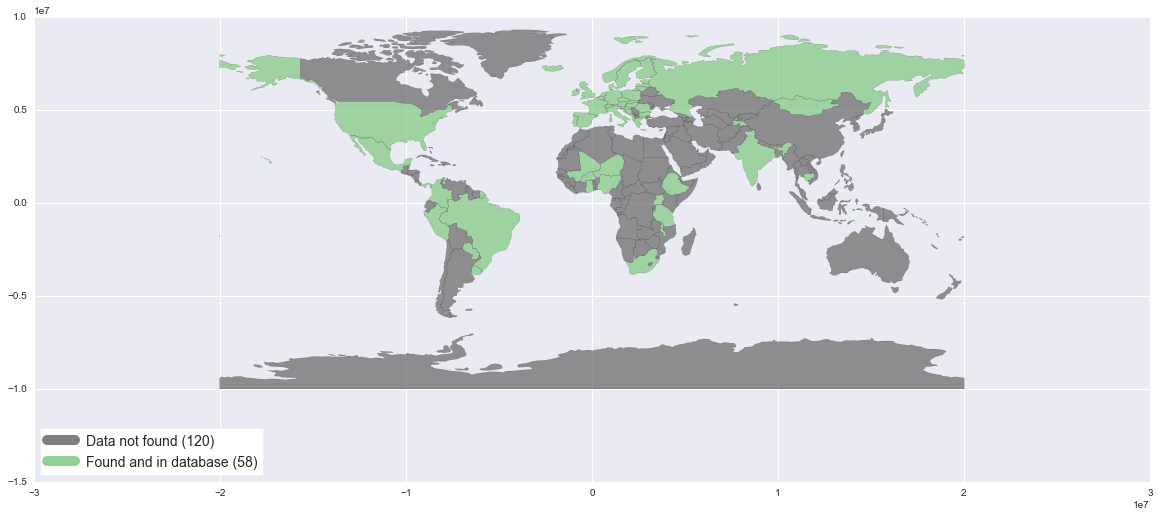

In [25]:
pivoted = pd.pivot_table(df, 
                         index='NAME_0', 
                         values='Crop', 
                         aggfunc=lambda x: len(x.unique()))
pivoted = pivoted.reset_index()
pivoted = pivoted.sort_values('Crop', ascending=False)
pivoted['Data_Available'] = pivoted['Crop'].astype(int)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world = world.to_crs(epsg=3786)

world = pd.merge(world, pivoted, 
                 how='outer', 
                 left_on='name', 
                 right_on='NAME_0')

world['Orig_crop'] = world['Crop'].fillna(0)
world['coverage'] = np.where(world['Crop'] > 0, 
                             'Found and downloaded', 
                             np.where(world['Crop'] == -1, 
                                      'Found not downloaded', 
                                      'No data found'))

warnings.filterwarnings('ignore')

x = len(pivoted.NAME_0.unique())

try:
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_aspect('equal')
    world.plot(column='coverage', cmap='Accent', ax=ax, alpha=0.7, linewidth=0.1)  #cmocean.cm.deep
except:
    pass

ndf, fad = world.coverage.value_counts()
cmap_ = cmocean.tools.get_dict(cmocean.cm.deep, N=4)

p1 = mpl.lines.Line2D([], [], 
                             color=[x / 255. for x in [128, 128, 130]],
                             linewidth=10, 
                             label='Data not found ({})'.format(ndf))
p2 = mpl.lines.Line2D([], [], 
                             color=[x / 255. for x in [148, 207, 150]], 
                             linewidth=10, 
                             label='Found and in database ({})'.format(fad))

handles = [p1, p2]
labels = [h.get_label() for h in handles] 

legend = ax.legend(handles=handles, labels=labels, frameon=True, 
                   fontsize=14, loc='lower left')

legend.get_frame().set_facecolor('#ffffff')

plt.show()

<a name="TemporalCoverage"></a>
<h2>Temporal Coverage</h2>

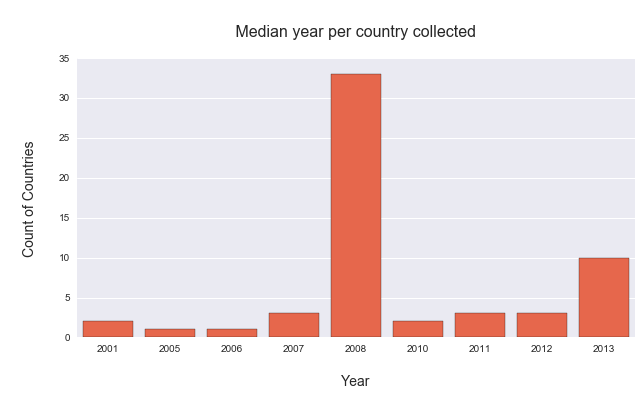

In [14]:
df = df.sort_values('NAME_0')
grouped = df.groupby('NAME_0').mean()
grouped['year'] = grouped['year'].astype(int)
grouped = grouped.sort('year')

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
sns.countplot(x=grouped.year, color='#FF5733', ax=ax)
ax.set_title('\n Median year per country collected \n', fontsize=title_sz-4)
ax.set_xlabel('\nYear\n', fontsize=y_lab_tick_sz-4)
ax.set_ylabel('\nCount of Countries\n', fontsize=y_lab_tick_sz-4)
mpl.rcParams['xtick.labelsize'] = x_lab_tick_sz-8
mpl.rcParams['ytick.labelsize'] = y_lab_tick_sz-8
plt.show()

<a name="ClassOverlaps"></a>
<h2>Farm size class overlaps</h2>

<p>First, I counted the number of records per farm size stratum, then plotted each farm size stratum by the amount of records per stratum.<br>

Here is the resulted graph of records per farm size stratum. The x-axis is the size of the farm size stratum, where each rectangle's horizontal plane represents the range the farm size stratum covers. The y-axis is the relative amount of records per farm size stratum; to make the overlaps easier to see, each subsequent rectangle starts a little higher than the previous (hence, the y-axis is only relative).</p>

In [16]:
df = df.query("fs_class_min != ['Total', 'defined', 'landless', 'undefined'] & "
              "fs_class_max != 'MORE'")

df['fs_class_min'] = df['fs_class_min'].astype(str).str.replace(u'+', '')
df['fs_class_min'] = df['fs_class_min'].astype(float)

# df['fs_class_min'] = (df['fs_class_min'] * 0.404686).where(df['fs_class_unit'] == 'acre') # not needed in the future

df['fs_class_max'] = df['fs_class_max'].astype(float)
# df['fs_class_max'] = (df['fs_class_max'] * 0.404686).where(df['fs_class_unit'] == 'acre') # not needed in the future

df['fs_Range'] = df['fs_class_min'].astype('str').map(str) + '_' + df['fs_class_max'].astype(str)

df = df.sort_values(['fs_Range'])

grouped = df.groupby(['fs_Range', 'fs_class_min', 'fs_class_max']).count()
grouped = grouped.reset_index()
grouped1 = grouped.loc[:, ['fs_Range', 'NAME_0']]
grouped2 = grouped1.fs_Range.str.split('_', expand=True)
grouped = grouped1.join(grouped2)
grouped.columns = ['fs_Range', 'Count', 'Low', 'High']
grouped['Low'] = grouped['Low'].astype(float)
grouped['High'] = grouped['High'].astype(float)
grouped = grouped.sort_values(['Low', 'High'])
# grouped['Count_sqrt'] = np.sqrt(grouped['Count'])
grouped['Count_sqrt'] = grouped['Count']
grouped['High'].fillna(-999, inplace=True)
grouped['High'] = np.where(grouped['High'] == -999, 100, grouped['High'])

In [27]:
def plt_farmSize_A(level=None, ax=ax):
    
    color = cm.get_cmap('Set2')
    # color2 = cm.rainbow(np.linspace(0,1,len(grouped)))
    
    for i in range(0, len(grouped)):
        
        try:
            verts = [
                (grouped['Low'][i], grouped['High'][i]), # left, bottom
                (grouped['Low'][i], grouped['Count_sqrt'][i]), # left, top
                (grouped['High'][i], grouped['Count_sqrt'][i]), # right, top
                (grouped['High'][i], grouped['High'][i]), # right, bottom
                (0., 0.), # ignored
                ]

            codes = [Path.MOVETO,
                     Path.LINETO,
                     Path.LINETO,
                     Path.LINETO,
                     Path.CLOSEPOLY,
                     ]

            path = Path(verts, codes)
            patch = patches.PathPatch(path, facecolor=color(4*i), lw=1, alpha=0.2)
            ax.add_patch(patch)    

        except:
            pass
        
    if level:
        ax.set_xlim(0, level[0])
        ax.set_ylim(0, level[1])
        
        major_ticks = np.arange(0, level[1], 2)                                              
        minor_ticks = np.arange(0, level[1], 1)                                               
        
    else:
        ax.set_xlim(0, grouped['Count_sqrt'].max() / 10)
        ax.set_ylim(-100, grouped['High'].max() + (grouped['High'].max() / 5))
        
        major_ticks = np.arange(0, grouped['High'].max(), round(grouped['High'].max()+1,0) / 10)                                             
        minor_ticks = np.arange(0, grouped['High'].max(), round(grouped['High'].max()+1,0) / 10)                                               
    
    ax.set_xticks(major_ticks)                                                       
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_title('\n Farm Size Stratum by Frequency of Stratum Used \n', fontsize=title_sz)
    ax.set_xlabel('\n Size (ha) \n', fontsize=x_lab_label_sz)
    ax.set_ylabel('\n Number of records \n', fontsize=x_lab_label_sz)
    mpl.rcParams['xtick.labelsize'] = x_lab_tick_sz
    mpl.rcParams['ytick.labelsize'] = y_lab_tick_sz

    return plt.show()

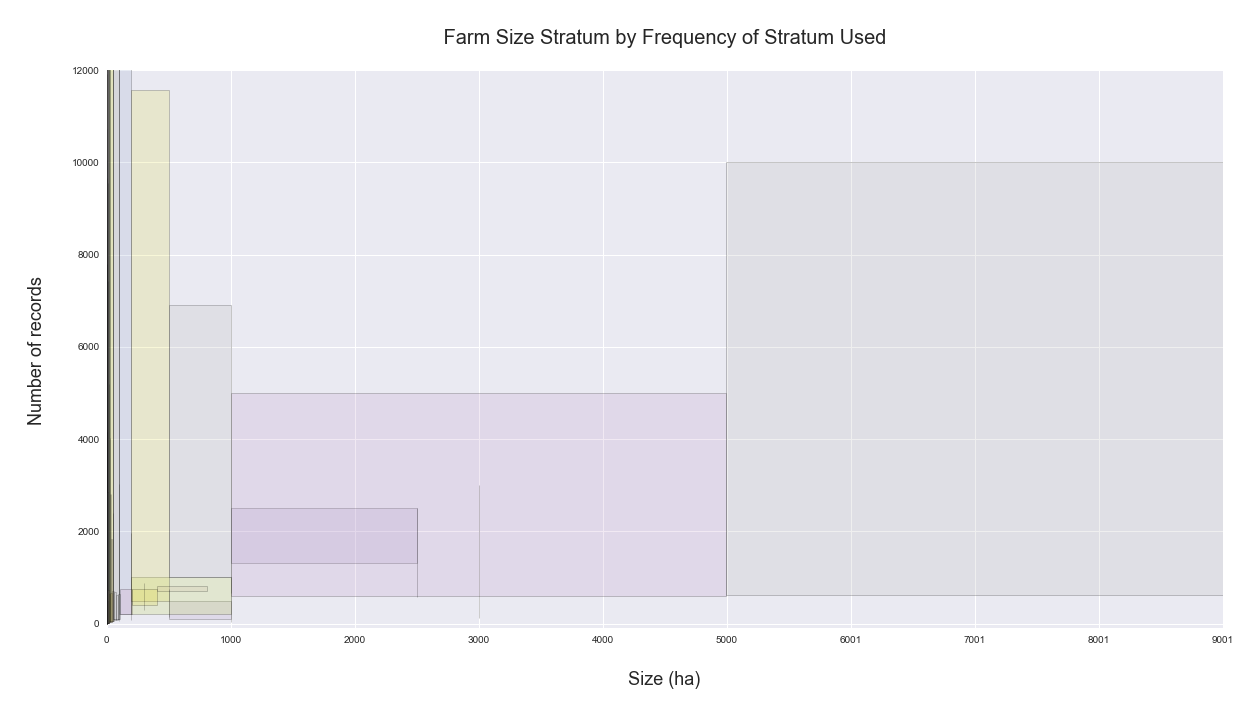

In [28]:
fig, ax = plt.subplots(figsize=(20, 10))
plt_farmSize_A(level=None, ax=ax)
# ax.set_xlim([0, 9])
plt.show()

From the above graph, the larger farm size stratum have less overlap, while the smaller farm size stratum contain a lot of overlap. Here is a zoomed in plot of the smaller farm size stratum.

*Note: if the acres are all covnerted to hectares, then there is no overlap, but if not converted there is a large amount of overlap - at this point, they are converted to ha , but I am not certain the data needs to be converted or is already in ha form.*

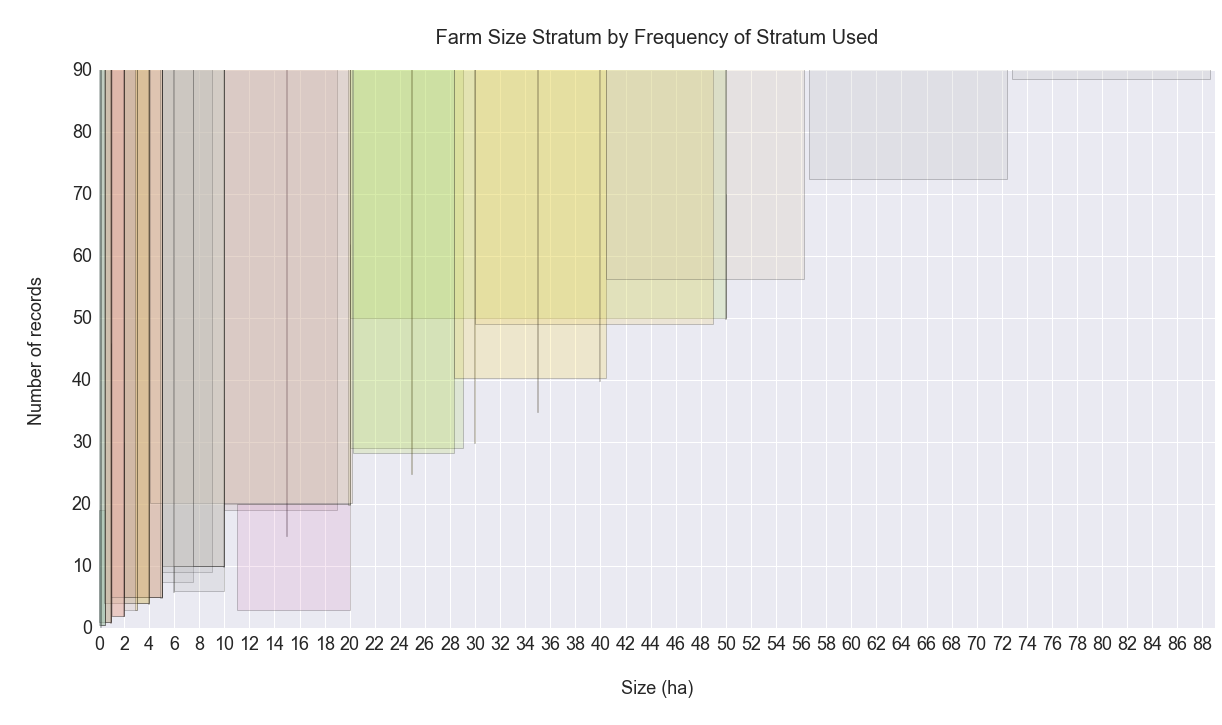

In [29]:
fig, ax = plt.subplots(figsize=(20, 10))
plt_farmSize_A(level=[1, 90], ax=ax)
plt.show()

<a name="LeftOff"></a>
<h3>Left Off</h3>

In [33]:
# dd = df
# grouped.fs_Range.unique()

# fig = plt.figure(figsize=(20, 10));
# ax = fig.add_subplot(111);

# sns.barplot(grouped['Count'], grouped['fs_Range'], 
#             linewidth=2.5, facecolor=(1, 1, 1, 0), 
#             errcolor='0.2', edgecolor='0.2',
#             ax=ax);
# ax.set_xlabel('');
# ax.set_ylabel('');

In [33]:
df.head()

,Unnamed: 0,Crop,Item_Code,NAME_0,NAME_1,NAME_2,NAME_3,es1,shpID,data_unit,fs_class_min,fs_class_max,cen_sur,microdata,year,Crop_area,Cultivated_area,Harvested_area,Planted_area,Production,Production_fix,Production_fix_dummy,Production_constant,perc_Feed,perc_Food,perc_Seed,perc_Waste,perc_Processing,perc_Other,production_Feed,production_Feed_k,production_Food,production_Food_k,production_Other,production_Other_k,production_Seed,production_Seed_k,production_Waste,production_Waste_k,production_Processing,production_Processing_k,kcal,fat,protein,production_Feed_kcal,production_Feed_k_kcal,production_Food_kcal,production_Food_k_kcal,production_Other_kcal,production_Other_k_kcal,production_Seed_kcal,production_Seed_k_kcal,production_Waste_kcal,production_Waste_k_kcal,production_Processing_kcal,production_Processing_k_kcal,production_Feed_fat,production_Feed_k_fat,production_Food_fat,production_Food_k_fat,production_Other_fat,production_Other_k_fat,production_Seed_fat,production_Seed_k_fat,production_Waste_fat,production_Waste_k_fat,production_Processing_fat,production_Processing_k_fat,production_Feed_protein,production_Feed_k_protein,production_Food_protein,production_Food_k_protein,production_Other_protein,production_Other_k_protein,production_Seed_protein,production_Seed_k_protein,production_Waste_protein,production_Waste_k_protein,production_Processing_protein,production_Processing_k_protein,fs_Range
277068,277068,Maize,56.0,South Africa,North West,1,1,ZAF,ZAF006,kg,0.0,0.5,sur,1,2013.0,NaN,NaN,NaN,NaN,3506.214143,3506.214143,0,NaN,0.353458,0.577147,0.011652,0.043327,3.134402e-03,0.013312,1239.299599,NaN,2023.601409,NaN,46.673506,NaN,40.855561,NaN,151.912037,NaN,10.989885,NaN,963.666667,8.643333,24.616667,1.194272e+06,NaN,1.950077e+06,NaN,4.497770e+04,NaN,39371.142355,NaN,146392.566499,NaN,1.059059e+04,NaN,10711.679531,NaN,17490.661513,NaN,403.414668,NaN,353.128233,NaN,1313.026375,NaN,94.989235,NaN,30507.425119,NaN,49814.321356,NaN,1148.946133,NaN,1005.727728,NaN,3739.567982,NaN,270.534324,NaN,0.0_0.5
517122,517122,Taro (cocoyam),136.0,South Africa,KwaZulu-Natal,1,1,ZAF,ZAF003,kg,0.0,0.5,sur,1,2013.0,NaN,NaN,NaN,NaN,2752.762018,2752.762018,0,NaN,0.945150,0.088123,0.088911,0.032152,6.978855e-01,0.923138,2601.772425,NaN,242.580561,NaN,2541.178647,NaN,244.750116,NaN,88.505907,NaN,1921.112714,NaN,6.785714,0.032621,0.398929,1.765488e+04,NaN,1.646082e+03,NaN,1.724371e+04,NaN,1660.804360,NaN,600.575799,NaN,1.303612e+04,NaN,84.872067,NaN,7.913188,NaN,82.895446,NaN,7.983961,NaN,2.887139,NaN,62.668359,NaN,1037.921357,NaN,96.772317,NaN,1013.748767,NaN,97.637814,NaN,35.307535,NaN,766.386751,NaN,0.0_0.5
64575,64575,"Beans, dry",176.0,South Africa,Limpopo,1,1,ZAF,ZAF004,kg,0.0,0.5,sur,1,2013.0,NaN,NaN,NaN,NaN,489505.717731,489505.717731,0,NaN,0.544437,0.880528,0.095791,0.023681,8.528724e-01,0.742447,266505.189514,NaN,431023.518971,NaN,363432.150132,NaN,46890.115329,NaN,11592.083431,NaN,417485.893937,NaN,8.666667,0.036667,0.586667,2.309712e+06,NaN,3.735537e+06,NaN,3.149745e+06,NaN,406380.999517,NaN,100464.723067,NaN,3.618211e+06,NaN,9771.856949,NaN,15804.195696,NaN,13325.845505,NaN,1719.304229,NaN,425.043059,NaN,15307.816111,NaN,156349.711182,NaN,252867.131130,NaN,213213.528077,NaN,27508.867660,NaN,6800.688946,NaN,244925.057776,NaN,0.0_0.5
356066,356066,"Onions, shallots, green",402.0,South Africa,KwaZulu-Natal,1,1,ZAF,ZAF003,kg,0.0,0.5,sur,1,2013.0,NaN,NaN,NaN,NaN,608.991577,608.991577,0,NaN,0.029214,0.872882,0.012694,0.097903,8.622064e-07,0.058187,17.791161,NaN,531.578067,NaN,35.435591,NaN,7.730775,NaN,59.622349,NaN,0.000525,NaN,27.333333,0.263333,1.220000,4.862917e+02,NaN,1.452980e+04,NaN,9.685728e+02,NaN,211.307854,NaN,1629.677549,NaN,1.435209e-02,NaN,4.685006,NaN,139.982224,NaN,9.331372,NaN,2.035771,NaN,15.700552,NaN,0.000138,NaN,21.705216,NaN,648.525241,NaN,43.231421,NaN,9.431546,NaN,72.739266,NaN,0.000641,NaN,0.0_0.5
356062,356062,"Onions, shallots, green",402.0,South Africa,Free State,1,1,ZAF,ZAF008,kg,0.0,0.5,sur,1,2013.0,NaN,NaN,NaN

To Do:
- We will need to see what these overlaps look like once the dataset compilation is complete, then determine the farm size classes we want to use.
- Also plot per farm size range on the y-axis, farm size on the x-axis??

In [45]:
pivot = pd.pivot_table(df, index=['NAME_0', 'fs_class_min', 'fs_class_max'], values='Production_fix', aggfunc='count')
pivot = pivot.reset_index()
pivot

,NAME_0,fs_class_min,fs_class_max,Production_fix
0,Albania,0.000000,1.000000,165
1,Albania,1.000000,2.000000,143
2,Albania,2.000000,5.000000,136
3,Albania,5.000000,10.000000,77
4,Albania,10.000000,20.000000,43
5,Albania,20.000000,50.000000,2
6,Albania,50.000000,100.000000,4
7,Austria,2.000000,4.000000,840
8,Austria,5.000000,9.000000,840
9,Austria,10.000000,19.000000,840


In [56]:
tmp = pivot.query("NAME_0 == 'Albania'")
# plt.barh(tmp['fs_class_min'], tmp['fs_class_max'])

<Container object of 7 artists>

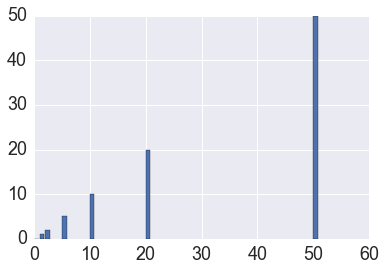

In [80]:
plt.bar(tmp['fs_class_min'], tmp['fs_class_min'])